#At Weather Insight, our goal is to provide accurate weather predictions to improve your bottom line. This notebook is a demonstration of our new gradient boost predictor, trained and tested with data taken from the Kaggle competition [How Much Did It Rain? II](https://www.kaggle.com/competitions/how-much-did-it-rain-ii/overview).


For the written report, [click here.](https://github.com/wck3/CS-301-104-Group-4/blob/main/docs/report.md)

Notebook Written by William Kaminski, Pedro Pacheco, Juan Lopez


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import timeit
from jax import jit
from sklearn.tree import DecisionTreeRegressor
from typing import Tuple, Union, List
from scipy import stats

# preprocessing/data manipulation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Data Import/Preprocessing

## Using data from Google Drive or downloading data from Kaggle

This is how you would run this notebook on Colab resources. There is the option to mount your Google Drive and obtain the data stored there, or you can download the data from Kaggle directly, using your personal authentication.

**Google Drive**

In [ ]:
#run if you are using data stored on your google drive
from google.colab import drive
drive.mount('/content/drive')

#use your google drive path if data is stored on drive
train = pd.read_csv('/content/drive/.../train.csv')

**Download data from Kaggle**

In [ ]:
#upload your authentication kaggle.json file
from google.colab import files
dummy = files.upload()

In [ ]:
#create Kaggle directory and copy your authentication JSON there
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download the dataset directly from Kaggle
!kaggle competitions download -c how-much-did-it-rain-ii

#unzips downloaded zip
!unzip  how-much-did-it-rain-ii.zip -d how_much_files

#unzips training and testing data into directory data/
!mkdir data
!unzip -qq how_much_files/train.zip -d data/
!unzip -qq how_much_files/test.zip -d data/

In [ ]:
#load the train set into a Pandas dataframe 
train = pd.read_csv('data/train.csv')

## Import and Run Using Local Data and Resources (our preferred method)

Due to resource limitations when using the free version of Colab, our sessions were continually cut short. The large computations on a large dataset required us to utilize our CUDA enabled GPUs. We connected this notebook to our local Jupyter servers with our custom made tutorial located [here](https://github.com/wck3/CS-301-104-Group-4/blob/main/docs/how_to_run.md).

In [ ]:
#Test to see if local runtime GPU is detected by jax
print(jax.default_backend())
print("Devices: ", jax.devices())

gpu
Devices:  [GpuDevice(id=0, process_index=0)]


In [ ]:
#If using a local runtime, you need to download the data from kaggle and locate it on your computer with a path similar to this:
train = pd.read_csv(r'C:\Users\...\...\train.csv')

## Reading the Data

Using the Pandas data analysis library, we are able to view and manipulate the training data. Our data reading and preprocessing was developed with  [this](https://www.kaggle.com/code/aleksanderkunicki/rain-regression) competition submission by Aleksander Kunicki as a key source of inspiration. 

In [ ]:
#See first five rows of the training data
train.head()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


In [ ]:
#Sanity check: display total columns and entries in the training dataset
train.shape

(13765201, 24)

In [ ]:
#getting the datatypes for all of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13765201 entries, 0 to 13765200
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Id                     int64  
 1   minutes_past           int64  
 2   radardist_km           float64
 3   Ref                    float64
 4   Ref_5x5_10th           float64
 5   Ref_5x5_50th           float64
 6   Ref_5x5_90th           float64
 7   RefComposite           float64
 8   RefComposite_5x5_10th  float64
 9   RefComposite_5x5_50th  float64
 10  RefComposite_5x5_90th  float64
 11  RhoHV                  float64
 12  RhoHV_5x5_10th         float64
 13  RhoHV_5x5_50th         float64
 14  RhoHV_5x5_90th         float64
 15  Zdr                    float64
 16  Zdr_5x5_10th           float64
 17  Zdr_5x5_50th           float64
 18  Zdr_5x5_90th           float64
 19  Kdp                    float64
 20  Kdp_5x5_10th           float64
 21  Kdp_5x5_50th           float64
 22  Kdp_5x5_90th    

In [ ]:
#group by ID to organize data
train.groupby(['Id']).mean()
train.head()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254


You can see that some of the radars are completely missing measurements. This is something that we will need to address.

## Preprocessing the data

In order to make the data usable, we need to change the NaN values. We assume these NaN values mean the measurements from the radar were either so small that they can be considered insignificant, or the measurement was nonexistent. We can simply set all of these values to 0 so that the features become usable.

In [ ]:
#all NaN features are set to 0
train.fillna(0, inplace = True)

Now you can see there are no NaN values in our data.

In [ ]:
train.isna().sum()

Id                       0
minutes_past             0
radardist_km             0
Ref                      0
Ref_5x5_10th             0
Ref_5x5_50th             0
Ref_5x5_90th             0
RefComposite             0
RefComposite_5x5_10th    0
RefComposite_5x5_50th    0
RefComposite_5x5_90th    0
RhoHV                    0
RhoHV_5x5_10th           0
RhoHV_5x5_50th           0
RhoHV_5x5_90th           0
Zdr                      0
Zdr_5x5_10th             0
Zdr_5x5_50th             0
Zdr_5x5_90th             0
Kdp                      0
Kdp_5x5_10th             0
Kdp_5x5_50th             0
Kdp_5x5_90th             0
Expected                 0
dtype: int64

When plotting the data, you can see that we have some very large outliers in the dataset. The Kaggle competition warns us of implausible measurements like this. This is likely due to the gauges being clogged. We will need to filter these values out in order to get a more accurate prediction.

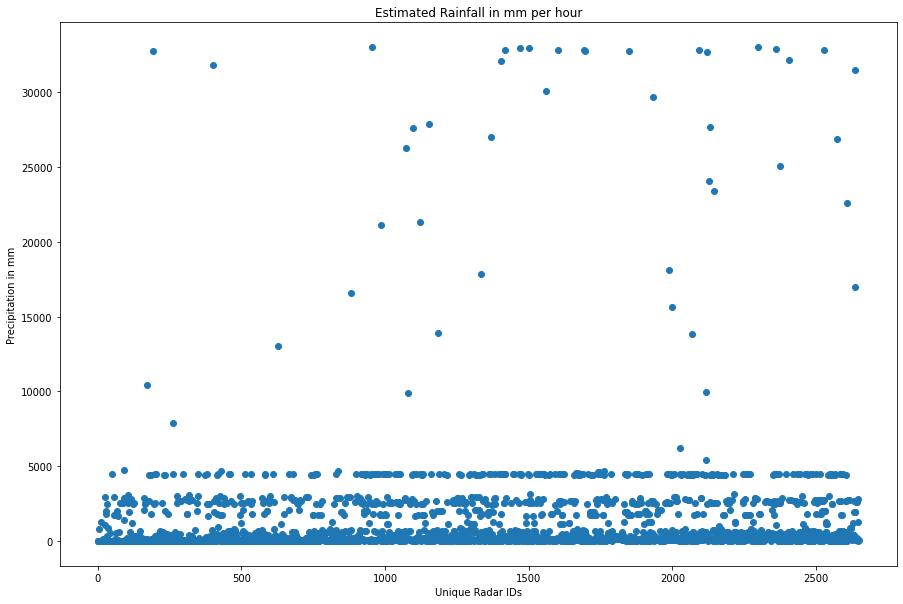

In [ ]:
#plot unfiltered data

plt.figure(figsize=(15, 10))
plt.title("Estimated Rainfall in mm per hour")
plt.xlabel("Unique Radar IDs"), plt.ylabel("Precipitation in mm")
plt.scatter(np.arange(len(train["Expected"].unique())), train["Expected"].unique())

As an assumption, it is unlikely that the precipitation levels will be anywhere above 106 mm (4 inches). Let's check the percentile of expected precipitation under 106 mm.

In [ ]:
print(stats.percentileofscore(train["Expected"], 106))

92.94511573060211


As you can see, a large portion of the data is below this threshold. In order to get a more accurate prediction, we can remove any measurements above 106 mm.

In [ ]:
# Exclude the outliers
train.drop(train[train["Expected"] >= 106].index, inplace=True)
train.head()
train.reset_index(drop=True, inplace=True)

In [ ]:
# Check new amount of observations
train.shape

(12794082, 24)

Our data looks cleaner:

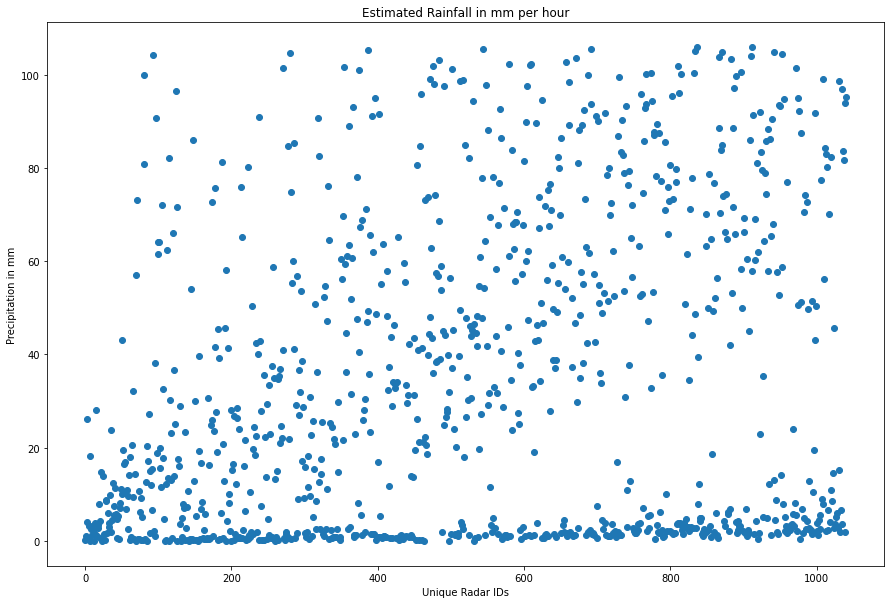

In [ ]:
#Plot new graph

plt.figure(figsize=(15, 10))
plt.title("Estimated Rainfall in mm per hour")
plt.xlabel("Unique Radar IDs"), plt.ylabel("Precipitation in mm")
plt.scatter(np.arange(len(train["Expected"].unique())), train["Expected"].unique())

### We have to work on grouped data (by 'Id' column)

The competition states that each ID corresponds to the radar measurements recorded in a single hour. However, there are multiple radar measurements recorded in a single hour and the ID's repeat in the dataset. In order to make a prediciton for each gauge, we will take the mean of all of the measurements for a single ID and group them together. 

In [ ]:
train_grouped = pd.DataFrame(train.groupby(['Id']).mean())

In [ ]:
train_grouped.head()

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
Id,,,,,,,,,,,,,,,,,,,,,
1,29.833333,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.254000
2,29.083333,2.0,16.625000,13.666667,17.375000,21.333333,22.666667,20.375000,22.916667,25.916667,...,1.000000,0.380208,0.119792,0.416667,0.781250,-0.264172,-1.08667,-0.292505,1.116661,1.016001
3,30.750000,10.0,0.000000,0.000000,0.000000,0.708333,0.000000,0.000000,0.000000,0.708333,...,0.066806,0.000000,0.000000,0.000000,0.171875,0.000000,0.00000,0.000000,0.000000,26.162014
4,28.153846,9.0,20.461538,10.807692,19.846154,30.269231,24.615385,17.846154,25.115385,32.230769,...,0.312564,-0.086538,0.000000,0.038462,0.466346,0.540769,0.00000,0.000000,0.973845,4.064002
6,29.833333,13.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.254000


In [ ]:
train_grouped.shape

(1080143, 23)

In [ ]:
train_grouped.head()
train.reset_index(drop=True, inplace=True)

Here we create a "target" set, which is our ground truth. We will use this later to compare our prediction on the entire dataset.

In [ ]:
target = train_grouped['Expected']

In [ ]:
target.shape

(1080143,)

## Prepare the data

We can use a sample of whole dataset to see which operations on data are most successful. Doing this allows us to use less resources and time so that we may experiment more with our algorithm.

In [ ]:
#create a subsample of the training dataset
train_sub = train_grouped.sample(n = 250000, random_state = 42)

In [ ]:
train_sub.shape

(250000, 23)

Converting our data into a scalar dataset may provide less error and a better prediction. Here we use scikit-learn's standard scaler to convert our feature subset.

In [ ]:
std_scaler = StandardScaler()

In [ ]:
sub_X = train_sub.drop(['minutes_past', 'Expected'], axis = 1)
sub_y = train_sub['Expected']
sub_X.reset_index(drop=True)
sub_X.head()

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
Id,,,,,,,,,,,,,,,,,,,,,
272210,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047262,0.000000,0.000000,0.000000,0.133929,0.000000,0.000000,0.000000,0.000000
222265,11.0,24.125000,18.291667,23.958333,31.000000,28.166667,22.333333,27.666667,33.875000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1013354,11.0,25.631579,19.131579,25.736842,31.657895,25.736842,20.868421,27.131579,32.631579,0.867807,...,0.935439,0.968597,0.305921,-0.575658,0.328947,2.174342,-1.304215,-2.736846,-1.030530,2.916310
514471,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1135419,13.0,12.678571,6.178571,12.428571,22.607143,17.178571,7.928571,16.464286,27.178571,0.440952,...,0.410952,0.524643,0.263393,-0.214286,0.000000,1.549107,-1.040003,-1.156430,-0.896431,1.589284


In order to train and test our model, we will further split the subset into test and train sets. Doing so will allow us to compare the results of our model and optimize parameters. We use scikit-learn's train_test_split function for random and easy splitting of the data.

In [ ]:
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(sub_X, sub_y, test_size = 0.2, random_state = 13)

In [ ]:
s_X_train_sc = std_scaler.fit_transform(s_X_train)

In [ ]:
s_X_test_sc = std_scaler.transform(s_X_test)

In [ ]:
s_X_train_sc.shape, s_X_test_sc.shape

((200000, 21), (50000, 21))

In [ ]:
s_y_train.shape, s_y_test.shape

((200000,), (50000,))

In [ ]:
s_y_test.head()

Id
71164      1.524001
1111409    0.508000
247453     0.254000
913990     0.508000
763348     0.508000
Name: Expected, dtype: float64

# Method: Our Gradient Boost Model

In [ ]:
#mean squared error (used as loss function in gradient boost)

def nojit_MSE(y: jnp.array, y_hat: jnp.array):
    return jnp.mean(jnp.sum(jnp.square(y - y_hat)))

mean_squared_error = jit(nojit_MSE)

In [ ]:
#mean absolute error (used for model accuracy)

def mean_absolute_error(y: np.array,y_hat:np.array):
    n = len(y)
    sum = 0

    for i in range(n):
        sum += jnp.abs(y[i] - y_hat[i])

    error = sum/n
    return error

In [ ]:
class GradientBoost:
    def __init__(
        self,
        #number of regression trees
        n_estimators: int = 100,
        #initial learning rate of the model
        learning_rate: float = 0.1,
        **kwargs
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        #loss calculated using mean squared error
        self.loss = mean_squared_error
 
        self.estimators = []
        #initialize regression trees
        for _ in range(self.n_estimators):
            self.estimators.append(DecisionTreeRegressor(**kwargs))
    #function to fit the model to the data
    def fit(self, X: jnp.array, y: jnp.array):
        #create an initial "dummy" prediction based on the mean of the labels
        y_hat = jnp.full(jnp.shape(y), jnp.mean(y))
        for i, estimator in enumerate(self.estimators):
            #compute the gradient of the loss function using jax
            gradient = jax.grad(self.loss, argnums=1)(
                y.astype(jnp.float32), y_hat.astype(jnp.float32)
            )
            #fit estimators with the gradient
            self.estimators[i].fit(X, gradient)
            #predict using the regression trees
            update = self.estimators[i].predict(X)
            #update the prediction value
            y_hat -= self.learning_rate * update
    
    #predict the data sequentially using the fitted model
    def predict(self, X: jnp.array):
        y_hat = jnp.zeros(X.shape[0], dtype=jnp.float32)
        for estimator in self.estimators:
            y_hat -= self.learning_rate * estimator.predict(X)
        return jnp.abs(y_hat)

In [ ]:
#Fitting the model
gb = GradientBoost()
gb.fit(jnp.asarray(s_X_train_sc, dtype=np.float32), jnp.asarray(s_y_train, dtype=np.float32))

In [ ]:
#Yielding a prediction
predict=gb.predict(jnp.asarray(s_X_test_sc, dtype=np.float32))

In [ ]:
#Mean absolute error as a metric to see the performance of our model
print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict))

4.263393


As you can see, our mean absolute error with these initial parameters seems very promising. Let us plot the predicted versus actual measured rainfall:

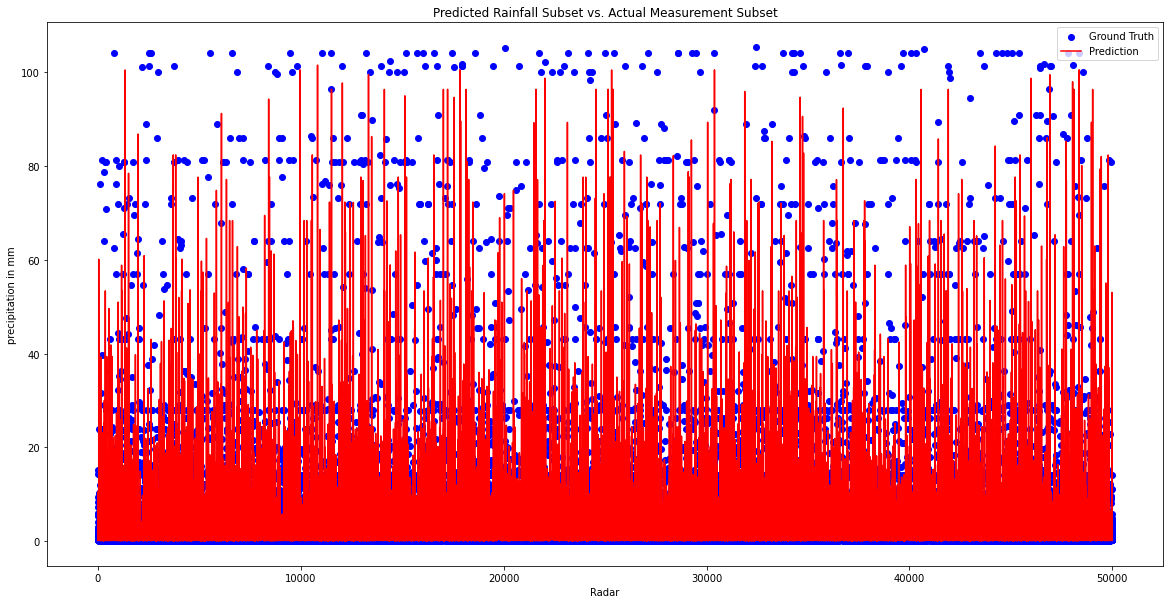

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall Subset vs. Actual Measurement Subset")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(s_y_test)),s_y_test, color="blue", label="Ground Truth")
plt.plot(np.arange(len(predict)),predict, color="red", label="Prediction")

plt.legend(loc="upper right")

plt.show()

This seems like a nice fit based on the mean absolute error and the graph above, but we experiment with hyper parameters to try to optimize the results to the best of our ability.

#Experimenting with JAX

We use the mean absolute function as an evaluation metric for our predictions. There are three different ways in which JAX can be incorporated into it:

1. JAX absolute value function (versus vanilla absolute value function)
2. JAX numpy arrays (as opposed to vanilla numpy arrays)
3. JIT to compile the function (versus no JIT)

That results in a total of 8 permutations, or cases. We will test each of them for speed below.

**Case 1**: Using vanilla absolute value function, vanilla numpy arrays and no JIT

In [ ]:
def mean_absolute_error(y: np.array,y_hat:np.array):
    n = len(y)
    sum = 0 
    for i in range(n):
        sum += abs(y[i] - y_hat[i])

    error = sum/n
    return error

%timeit print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict))

4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
1min 12s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Case 2**:
Using JAX numpy absolute value function, vanilla numpy arrays and no JIT

In [ ]:
def mean_absolute_error(y: np.array,y_hat:np.array):
    n = len(y)
    sum = 0

    for i in range(n):
        sum += jnp.abs(y[i] - y_hat[i])

    error = sum/n
    return error

%timeit print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict))

4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
1min 11s ± 343 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Case 3**: Using JAX numpy absolute value function, JAX numpy arrays and no JIT:

In [ ]:
def mean_absolute_error(y: jnp.array,y_hat:jnp.array):
    n = len(y)
    sum = 0

    for i in range(n):
        sum += jnp.abs(y[i] - y_hat[i])

    error = sum/n
    return error

%timeit print(mean_absolute_error(jnp.asarray(s_y_test, dtype=jnp.float32),  predict))

4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
2min 8s ± 553 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note**: Unfortunately, we cannot test Cases 4 and 5 below as these combinations crash our computers.

**Case 4**: Using JAX numpy absolute value function, vanilla numpy arrays and JIT. (It does not run)

In [ ]:
##******************************************************************************
## Unfortunately, we cannot test this as this combination crashes our computers.
##
##                        PLEASE DO NOT RUN
##
##******************************************************************************

# def u_mean_absolute_error(y:np.array,y_hat:np.array):
#     n = len(y)
#     sum = 0

#     for i in range(n):
#         sum += jnp.abs(y[i] - y_hat[i])

#     error = sum/n
#     return error

# mean_absolute_error = jax.jit(u_mean_absolute_error)

# %timeit print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict))

**Case 5**: Using JAX numpy absolute value function, JAX numpy arrays and JIT (It does not run)

In [ ]:
##******************************************************************************
## Unfortunately, we cannot test this as this combination crashes our computers.
##
##                        PLEASE DO NOT RUN
##
##******************************************************************************

# def u_mean_absolute_error(y: jnp.array,y_hat:jnp.array):
#     n = len(y)
#     sum = 0

#     for i in range(n):
#         sum += jnp.abs(y[i] - y_hat[i])

#     error = sum/n
#     return error

# mean_absolute_error = jax.jit(u_mean_absolute_error)

# %timeit print(mean_absolute_error(jnp.asarray(s_y_test, dtype=jnp.float32),  predict))

**Case 6**: Using vanilla absolute value function, JAX numpy arrays and no JIT


In [ ]:
def mean_absolute_error(y: jnp.array,y_hat:jnp.array):
    n = len(y)
    sum = 0

    for i in range(n):
        sum += abs(y[i] - y_hat[i])

    error = sum/n
    return error

%timeit print(mean_absolute_error(jnp.asarray(s_y_test, dtype=jnp.float32),  predict))

4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
4.277514
2min 7s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note**: Unfortunately, we cannot test Cases 7 and 8 below as these combinations crash our computers.

**Case 7**: Using vanilla absolute value function, JAX numpy arrays and JIT (it does not run)

In [ ]:
##******************************************************************************
## Unfortunately, we cannot test this as this combination crashes our computers.
##
##                        PLEASE DO NOT RUN
##
##******************************************************************************

# def u_mean_absolute_error(y: jnp.array,y_hat:jnp.array):
#     n = len(y)
#     sum = 0

#     for i in range(n):
#         sum += abs(y[i] - y_hat[i])

#     error = sum/n
#     return error

# mean_absolute_error = jax.jit(u_mean_absolute_error)

# %timeit print(mean_absolute_error(jnp.asarray(s_y_test, dtype=jnp.float32),  predict))

**Case 8**: Using vanilla absolute value function, vanilla numpy arrays and JIT (it does not run)

In [ ]:
##******************************************************************************
## Unfortunately, we cannot test this as this combination crashes our computers.
##
##                        PLEASE DO NOT RUN
##
##******************************************************************************

# def u_mean_absolute_error(y: np.array,y_hat:np.array):
#     n = len(y)
#     sum = 0

#     for i in range(n):
#         sum += abs(y[i] - y_hat[i])

#     error = sum/n
#     return error

# mean_absolute_error = jax.jit(u_mean_absolute_error)

# %timeit print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict))

Here are the results:

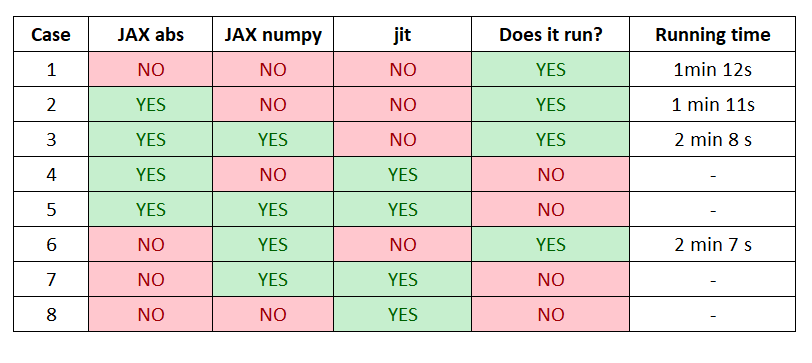

Thus, we can conclude that using jax.jit for this function makes it unable to run. Using JAX numpy arrays instead of vanilla numpy arrays increases the running time significantly, to almost double. Using the JAX absolute value function does not seem to have any effect on runtime.

# Experimentation With Hyperparameters

Our model seems to fit the data well with the initial parameters given, with the number of trees being 100 and a learning rate of 0.01. We want to see if we can make our prediction better by experimenting with these hyperparameters. We continue to work on the training and testing subset of 250,000 from the provided training dataset.

###Test 1

In our first attempt, we will keep the number of estimators at 100 and decrease the learning rate to 0.001, a very common learning rate. 

In [ ]:
gbtest_1 = GradientBoost(learning_rate=0.001)

In [ ]:
gbtest_1.fit(jnp.asarray(s_X_train_sc, dtype=np.float32), jnp.asarray(s_y_train, dtype=np.float32))

In [ ]:
predict1 = gbtest_1.predict(jnp.asarray(s_X_test_sc, dtype=np.float32))

In [ ]:
print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict1))

4.275684


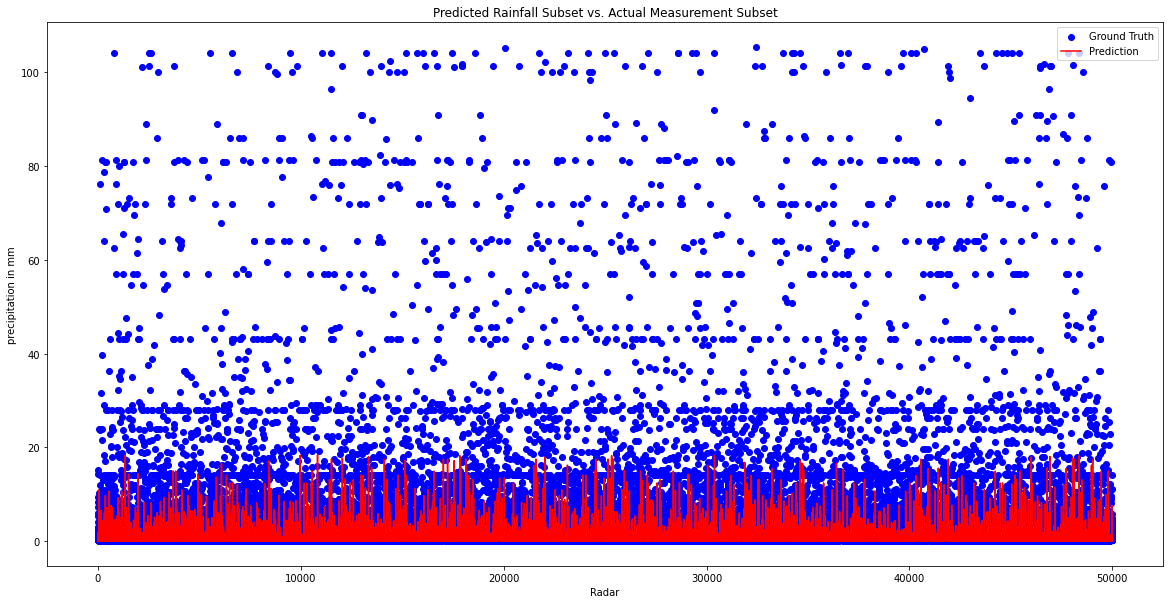

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall Subset vs. Actual Measurement Subset (Learning Rate of 0.001)")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(s_y_test)),s_y_test, color="blue", label="Ground Truth")
plt.plot(np.arange(len(predict1)),predict1, color="red", label="Prediction")

plt.legend(loc="upper right")

plt.show()

You can see the prediction labeled in red is underfitting by a large margin. 

###Test 2
Here, we keep the learning rate at 0.001 and increase the number of estimators by 50, to a total of 150. 

In [ ]:
gbtest_2 = GradientBoost(learning_rate=0.001, n_estimators=150)

In [ ]:
gbtest_2.fit(jnp.asarray(s_X_train_sc, dtype=np.float32), jnp.asarray(s_y_train, dtype=np.float32))

In [ ]:
predict2 = gbtest_2.predict(jnp.asarray(s_X_test_sc, dtype=np.float32))

In [ ]:
print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict2))

3.291004


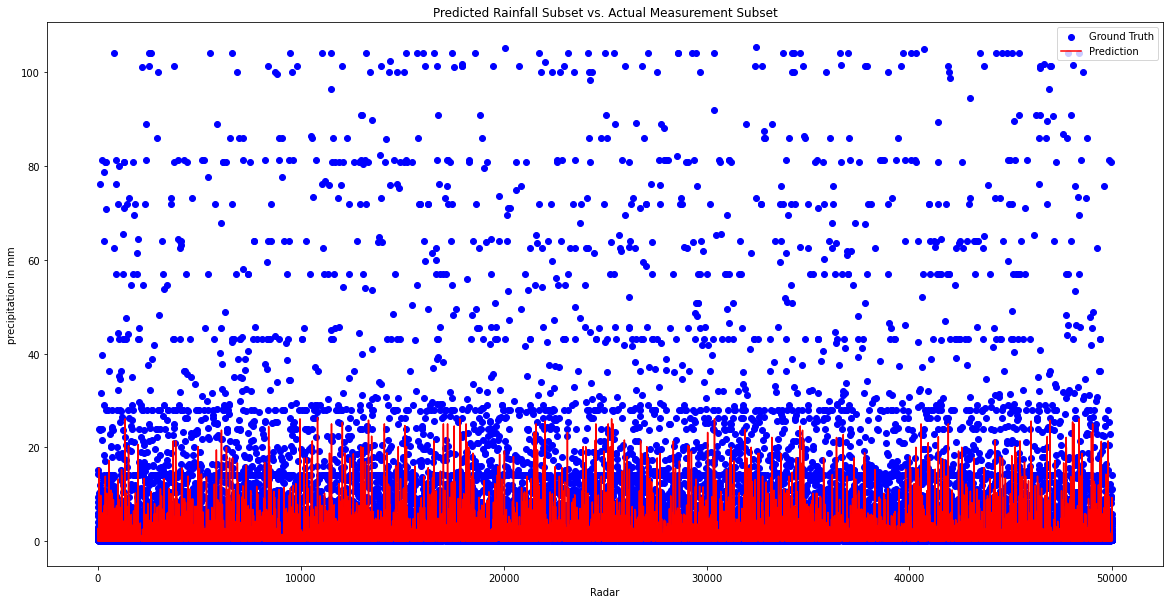

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall Subset vs. Actual Measurement Subset learning rate of 0.001, n=150")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(s_y_test)),s_y_test, color="blue", label="Ground Truth")
plt.plot(np.arange(len(predict2)),predict2, color="red", label="Prediction")

plt.legend(loc="upper right")

plt.show()

The model seems to be underfitting a bit less, but not by a significant margin.

###Test 3

Since the data was underfitting less after increasing the number of estimators and it was underfitting more when we decreased the size of the learning rate, we will try to meet in the middle. We set the learning rate to 0.1 and the number of estimators to 150. 


In [ ]:
gbtest_3 = GradientBoost(learning_rate=0.1, n_estimators=150)

In [ ]:
gbtest_3.fit(jnp.asarray(s_X_train_sc, dtype=np.float32), jnp.asarray(s_y_train, dtype=np.float32))

In [ ]:
predict3 = gbtest_3.predict(jnp.asarray(s_X_test_sc, dtype=np.float32))

In [ ]:
print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict3))

4.270934


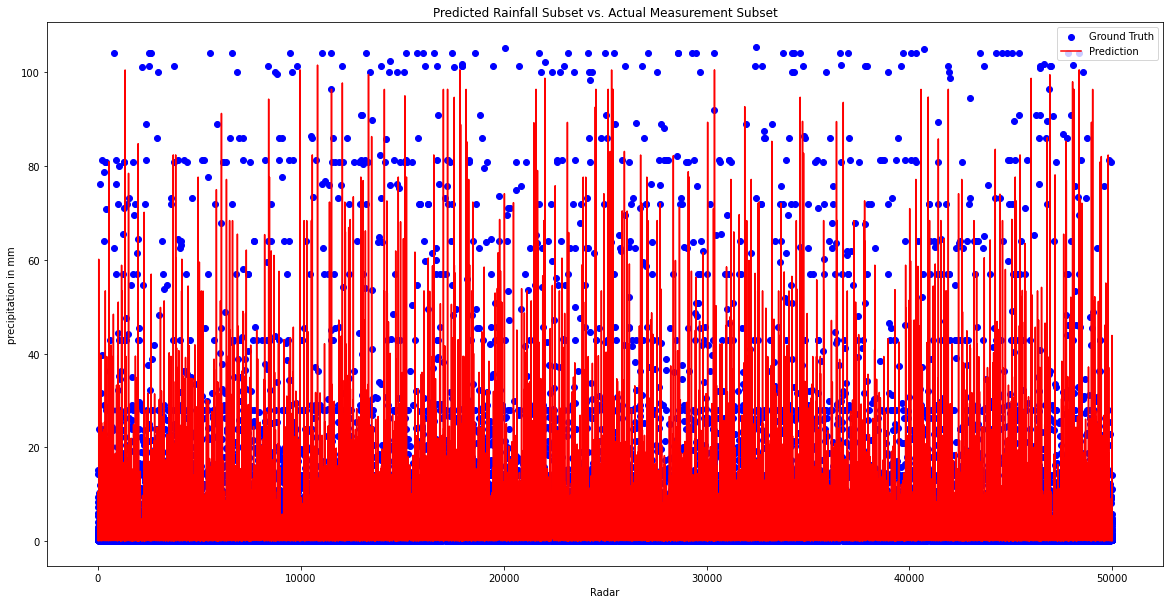

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall Subset vs. Actual Measurement Subset (Learning rate of 0.1, n=150)")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(s_y_test)),s_y_test, color="blue", label="Ground Truth")
plt.plot(np.arange(len(predict3)),predict3, color="red", label="Prediction")

plt.legend(loc="upper right")

plt.show()

The model fits much better with these parameters, but we can do better. 

###Test 4
After the success with increasing the number of estimators, we further increase the number of estimators by 100, to a total of 250.


In [ ]:
gbtest_4 = GradientBoost(learning_rate=0.01, n_estimators=250)

In [ ]:
gbtest_4.fit(jnp.asarray(s_X_train_sc, dtype=np.float32), jnp.asarray(s_y_train, dtype=np.float32))

In [ ]:
predict4 = gbtest_4.predict(jnp.asarray(s_X_test_sc, dtype=np.float32))

In [ ]:
print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict4))

4.248883


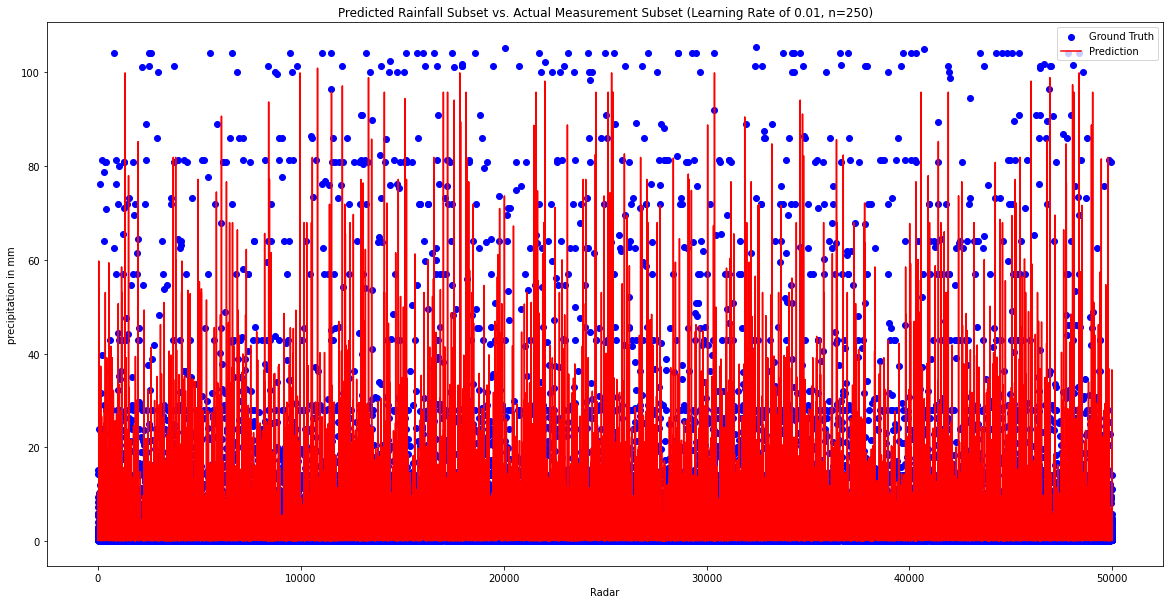

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall Subset vs. Actual Measurement Subset (Learning Rate of 0.01, n=250)")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(s_y_test)),s_y_test, color="blue", label="Ground Truth")
plt.plot(np.arange(len(predict4)),predict4, color="red", label="Prediction")

plt.legend(loc="upper right")

plt.show()

Our result was slightly better.

###Test 5
We will attempt one more increase of the number of estimators, increasing them by 150 to a total of 400.


In [ ]:
gbtest_5 = GradientBoost(learning_rate=0.01, n_estimators=400)

In [ ]:
gbtest_5.fit(jnp.asarray(s_X_train_sc, dtype=np.float32), jnp.asarray(s_y_train, dtype=np.float32))

In [ ]:
predict5 = gbtest_5.predict(jnp.asarray(s_X_test_sc, dtype=np.float32))

In [ ]:
print(mean_absolute_error(np.asarray(s_y_test, dtype=np.float32),  predict5))

4.2629223


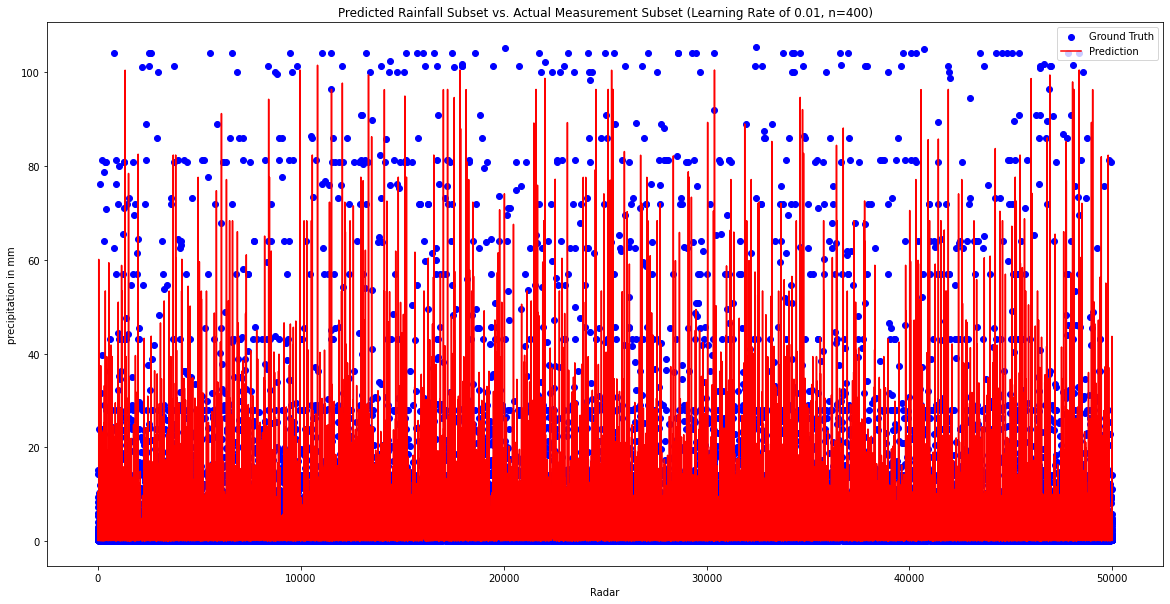

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall Subset vs. Actual Measurement Subset (Learning Rate of 0.01, n=400)")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(s_y_test)),s_y_test, color="blue", label="Ground Truth")
plt.plot(np.arange(len(predict5)),predict5, color="red", label="Prediction")

plt.legend(loc="upper right")

plt.show()

It has not seemed to have made a significant difference. In order to conserve resources, it seems like a better choice to use only 250 estimators.

# Predicting the Test Data Finalized Hyperparameters

Now that we have seen that our model is successful, we can use the finalized hyperparameters on the test dataset provided in the kaggle competition. We will perform the same preprocessing on this data as was done previously on the training data. 

In [ ]:
#Loading the training data from local storage into a Pandas dataframe

test = pd.read_csv(r'C:\Users\...\...\test.csv')


In [ ]:
test.groupby(['Id']).mean()

,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
Id,,,,,,,,,,,,,,,,,,,,,
1,29.823529,8.0,10.500000,NaN,8.277778,13.461538,11.375000,NaN,8.666667,14.153846,...,0.990000,1.043571,-0.546875,-1.7500,0.062500,2.598214,-1.523336,NaN,-1.290003,2.601664
2,28.937500,15.0,NaN,NaN,NaN,13.000000,NaN,NaN,NaN,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28.700000,11.0,23.722222,17.125000,24.111111,34.700000,25.055556,16.400000,25.222222,36.350000,...,0.954667,0.981333,0.418750,-0.5625,0.456250,1.825000,0.219994,-4.359003,0.169997,5.382997
4,28.727273,9.0,30.812500,28.642857,29.812500,35.625000,32.000000,28.944444,32.666667,35.250000,...,0.970556,0.982143,0.100000,-0.5375,0.177083,1.241071,0.911996,-2.890003,-0.140002,5.563329
5,28.333333,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717621,28.400000,6.0,14.500000,9.000000,12.750000,16.500000,12.800000,7.333333,8.714286,16.133333,...,NaN,1.023333,NaN,NaN,NaN,0.750000,NaN,NaN,NaN,-0.935005
717622,29.285714,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717623,30.307692,9.0,21.833333,19.055556,22.916667,31.192308,26.000000,22.318182,24.576923,32.730769,...,0.968077,0.993718,0.168269,-1.1875,0.168269,1.750000,-0.083082,-4.716925,-0.188466,4.841534


In [ ]:
#all NaN features are set to 0
test.fillna(0, inplace = True)

In [ ]:
test_grouped = pd.DataFrame(test.groupby(['Id']).mean())

In [ ]:
test_grouped = test_grouped.drop(['minutes_past'], axis = 1)

In [ ]:
test_grouped.reset_index(drop=True)

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
0,8.0,4.941176,0.000000,4.382353,10.294118,5.352941,0.000000,4.588235,10.823529,0.238039,...,0.232941,0.429706,-0.128676,-0.102941,0.014706,1.069853,-0.268824,0.000000,-0.227648,0.918234
1,15.0,0.000000,0.000000,0.000000,0.812500,0.000000,0.000000,0.000000,0.812500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,11.0,21.350000,6.850000,21.700000,34.700000,22.550000,8.200000,22.700000,36.350000,0.927333,...,0.954667,0.981333,0.418750,-0.562500,0.456250,1.825000,0.219994,-4.359003,0.169997,5.382997
3,9.0,22.409091,18.227273,21.681818,25.909091,26.181818,23.681818,26.727273,32.045455,0.439848,...,0.529394,0.625000,0.045455,-0.244318,0.096591,0.789773,0.414544,-1.313638,-0.063637,3.034543
4,17.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717620,6.0,3.866667,1.200000,3.400000,13.200000,4.266667,1.466667,4.066667,16.133333,0.000000,...,0.000000,0.136444,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,-0.124667
717621,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
717622,9.0,20.153846,13.192308,21.153846,31.192308,24.000000,18.884615,24.576923,32.730769,0.976538,...,0.968077,0.993718,0.168269,-1.187500,0.168269,1.750000,-0.083082,-4.716925,-0.188466,4.841534
717623,11.0,5.428571,0.000000,5.285714,18.357143,5.428571,0.000000,5.357143,21.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
train_grouped = train_grouped.drop(['minutes_past', 'Expected'], axis = 1)

In [ ]:
X_train = std_scaler.fit_transform(train_grouped)

In [ ]:
train_sub.drop(['minutes_past', 'Expected'], axis = 1)

,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,...,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th
Id,,,,,,,,,,,,,,,,,,,,,
272210,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047262,0.000000,0.000000,0.000000,0.133929,0.000000,0.000000,0.000000,0.000000
222265,11.0,24.125000,18.291667,23.958333,31.000000,28.166667,22.333333,27.666667,33.875000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1013354,11.0,25.631579,19.131579,25.736842,31.657895,25.736842,20.868421,27.131579,32.631579,0.867807,...,0.935439,0.968597,0.305921,-0.575658,0.328947,2.174342,-1.304215,-2.736846,-1.030530,2.916310
514471,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1135419,13.0,12.678571,6.178571,12.428571,22.607143,17.178571,7.928571,16.464286,27.178571,0.440952,...,0.410952,0.524643,0.263393,-0.214286,0.000000,1.549107,-1.040003,-1.156430,-0.896431,1.589284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182300,1.0,0.000000,0.000000,0.000000,-6.416667,0.666667,-1.000000,0.666667,0.333333,0.297778,...,0.274444,0.589167,-0.093750,-0.197917,-0.468750,-0.208333,0.000000,0.000000,0.000000,0.000000
984952,11.0,40.035714,33.642857,40.071429,46.285714,42.285714,35.214286,41.071429,47.214286,0.000000,...,0.000000,0.225357,0.000000,0.000000,0.000000,0.321429,0.000000,0.000000,0.000000,1.725715
1063309,14.0,11.961538,8.500000,13.230769,17.576923,12.923077,10.500000,13.923077,17.807692,0.307179,...,0.231667,0.401923,0.052885,0.000000,0.004808,0.326923,-0.601539,0.000000,-0.267692,1.277691


In [ ]:
X_train.shape

(1080143, 21)

In [ ]:
X_test = std_scaler.transform(test_grouped)

In [ ]:
X_test.shape

(717625, 21)

We will now train the model with a learning rate of 0.01 and 250 estimators using all of the training features. We will then predict using all of the the test features.

In [ ]:
gb_final = GradientBoost(learning_rate=0.01, n_estimators=250)

In [ ]:
gb_final.fit(jnp.asarray(X_train, dtype=np.float32), jnp.asarray(target, dtype=np.float32))

In [ ]:
predict = gb_final.predict(jnp.asarray(X_test, dtype=np.float32))

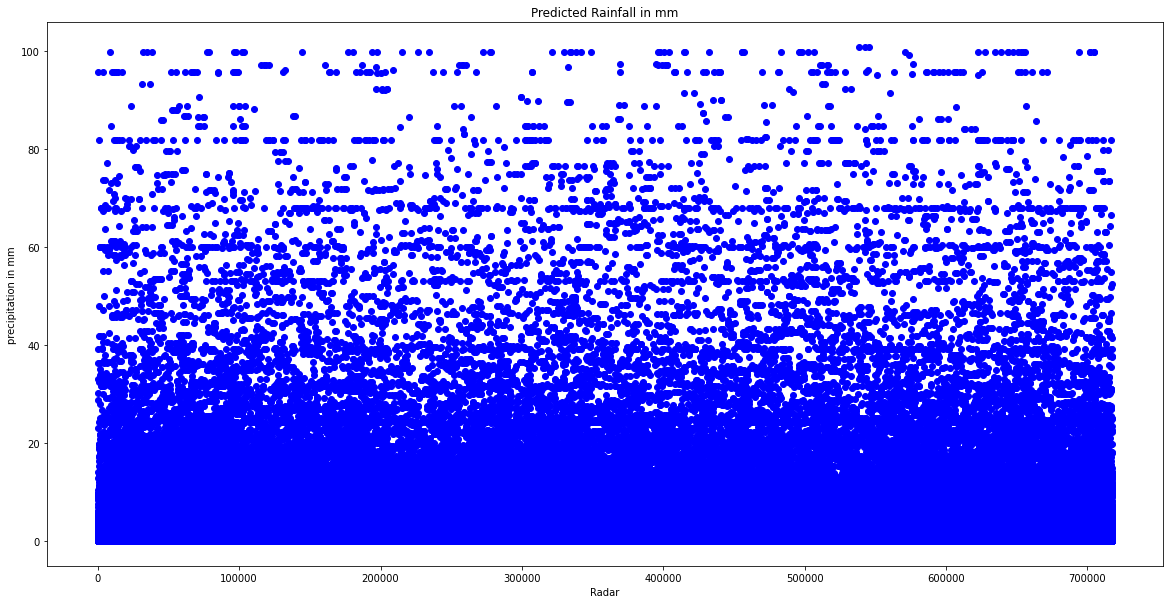

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Predicted Rainfall in mm")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(predict)),predict, color="blue")

plt.show()

Plotting the "ground truth" measurements from the radar. This is the set excluding the outliers that we removed earlier.

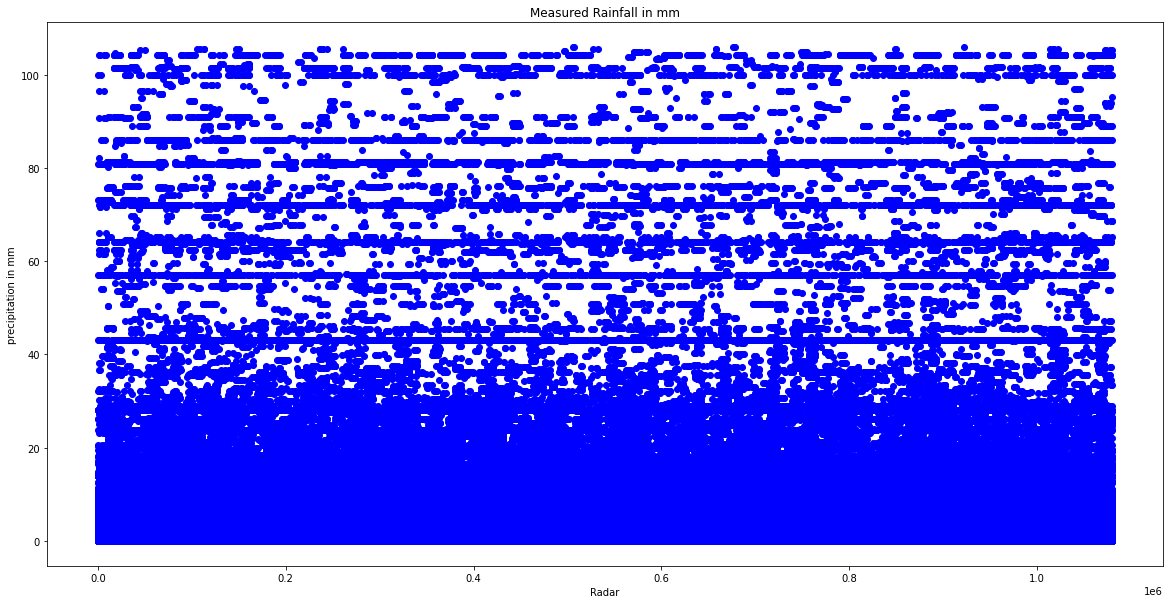

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Measured Rainfall in mm")
plt.xlabel("Radar"); plt.ylabel("precipitation in mm");
plt.scatter(np.arange(len(target)),target, color="blue")

plt.show()